# PySpice

 Video tutorial accompanying this notebook can be found [here](https://www.youtube.com/watch?v=3QyAJCCmsRs).

## Introduction

PySpice is a Python-based library that provides a convenient interface for
simulating and analyzing electronic circuits using SPICE.

With PySpice, you can define circuits using Python and simulate their behavior
using SPICE simulations. You can also visualize and analyze the results of
these simulations using Python's powerful data manipulation and visualization
tools.

### Installation

Steps to install PySpice within a conda environment:

- `conda create -n pyspice`
- `conda activate pyspice`
- `conda install -c conda-forge pyspice`
- `conda install -c conda-forge ngspice ngspice-lib`
- `conda install ipykernel`
- `ipython kernel install --user --name=pyspice`

## Import Relevant Modules

In [1]:
from PySpice.Spice.Netlist import Circuit # for creating circuits
from PySpice.Unit import *                # for using units

To turn off warnings about unsupported ngspice versions in PySpice, you can set
the logging level to ERROR, which will suppress the warning messages.

In [2]:
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging(logging_level=Logging.logging.ERROR)

Import numpy and matplotlib for data analysis and plotting.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Use LaTex fonts/style in plots (make sure you have a LaTex backend installed).

In [4]:
import matplotlib

matplotlib.rcParams.update({'font.size': 14,
                            'text.usetex': True,      # use TeX backend
                            'mathtext.fontset': 'cm', # computer modern
                            'mathtext.rm': 'serif'})

## Template

The process of creating and simulating a circuit in PySpice can be summarized as follows:

- Create a circuit instance
- Add components to the circuit
- Set up the simulator
- Simulate the circuit
- Read the result

## Example 1: Basics

The objective of this section is to illustrate with a simple example the steps
involved in the conversion of a circuit from schematic to a netlist, performing
a simulation, and subsequently retrieving the simulation output.

![circuit1](./images/cir1.svg)

### Build netlist

Instantiate a circuit instance

In [6]:
circuit = Circuit('Resistive Divider')

Add components to the circuit as shown in the schematic above

In [7]:
circuit.V(1, 'n_in', circuit.gnd, 10@u_V)
circuit.R(1, 'n_in', 'n_out', 2@u_kOhm)
circuit.R(2, 'n_out', circuit.gnd, 6@u_kOhm)
circuit.R(3, 'n_out', circuit.gnd, 6e3) # you can also pass the actual value directly

Resistor R3

Print the netlist so far

In [8]:
print(circuit)

.title Resistive Divider
V1 n_in 0 10V
R1 n_in n_out 2kOhm
R2 n_out 0 6kOhm
R3 n_out 0 6000.0



### Set up simulator

Create a simulator object (with some parameters)

In [10]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
print(simulator)

.title Resistive Divider
V1 n_in 0 10V
R1 n_in n_out 2kOhm
R2 n_out 0 6kOhm
R3 n_out 0 6000.0
.options TEMP = 25C
.options TNOM = 25C
.end



If a temperature is not set, the default of 27C is used.

### Run analysis

Run operating point analysis

In [11]:
analysis = simulator.operating_point()

### Read result

Result of the analysis can be accessed via the `analysis` object.

- Votages can be accessed via `analysis.nodes`
- Currents can be accessed via `analysis.branches`
- Time values (for transient analysis) can be accessed via `analysis.time`
- Frequency values (for ac analysis) can be accessed via `analysis.frequency`
- Sweep values (for dc sweep) can be accessed via `analysis.sweep`
- Internal parameters can be retrieved from `analysis.internal_parameters`

The above objects are dictionaries, where the keys are the node/branch names
and the values are the result of the simulation. In PySpice, the values are of
`WaveForm` type, and are stored as `numpy` arrays.

Print out node and branch names

In [12]:
analysis.nodes.keys()

dict_keys(['n_out', 'n_in'])

In [13]:
analysis.branches.keys()

dict_keys(['v1'])

Print out the voltage values

In [21]:
for node in analysis.nodes.values():
    print(f"{str(node)}: {float(node)}V")

n_out: 6.0V
n_in: 10.0V


Print out the current through the independent voltage sources

In [22]:
for branch in analysis.branches.values():
    print(f"{str(branch)}: {float(branch)}A")

v1: -0.002A


Notice that we do not get the currents through the resistors. This is
because, by default, SPICE saves only the currents through the independent
voltage sources.

To save the currents through all the components, we need to need to explicitly
set the `savecurrents` option.

In [23]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.save_currents = True
analysis = simulator.operating_point()

In [24]:
for param in analysis.internal_parameters.values():
    print(f"{str(param)}: {float(param)}A")

@r3[i]: 0.001A
@r2[i]: 0.001A
@r1[i]: 0.002A


## Example 2: Creating Subcircuits

The purpose of this section is to demonstrate the use of a subcircuit. In
essence, a subcircuit is a small circuit that is part of a larger circuit. Once
created, a subcircuit can be used multiple times in different parts of a
circuit or in entirely different circuits, eliminating the need to recreate the
same functionality repeatedly. The parameters of the subcircuit can be modified
when used in different contexts, allowing for flexibility in design. This
feature not only saves time but also helps to maintain consistency across
circuit designs.

![circuit5](./images/cir5.svg)

In [25]:
from PySpice.Spice.Netlist import SubCircuit # for creating subcircuits

Let's create an RC subcircuit that we can reuse

In [26]:
class RC(SubCircuit):
    __nodes__ = ('n1', 'n2')
    def __init__(self, name, R1=1@u_kOhm, C1=10@u_uF): # default values for the components
        SubCircuit.__init__(self, name, *self.__nodes__)
        self.R(1, 'n1', 'n2', R1)
        self.C(1, 'n2', circuit.gnd, C1)

In [27]:
# instantiate a new circuit instance
circuit = Circuit('Second Order RC Circuit')

Add the subcircuit to the netlist so that it can be used like any other component.

In [29]:
circuit.subcircuit(RC(name='RC_BLOCK', C1=1@u_uF))
print(circuit)

.title Second Order RC Circuit
.subckt RC_BLOCK n1 n2
R1 n1 n2 1kOhm
C1 n2 0 1uF
.ends RC_BLOCK




Use the subcircuit like any other circuit component (subcircuit uses the symbol X)

In [30]:
circuit.SinusoidalVoltageSource(1, 'n_in', circuit.gnd, amplitude=1@u_V)
circuit.X('1', 'RC_BLOCK', 'n_in', 'n_12')
circuit.X('2', 'RC_BLOCK', 'n_12', 'n_out') # notice that we are using the same subcircuit here
print(circuit)

.title Second Order RC Circuit
.subckt RC_BLOCK n1 n2
R1 n1 n2 1kOhm
C1 n2 0 1uF
.ends RC_BLOCK
V1 n_in 0 DC 0V AC 1V SIN(0V 1V 50Hz 0s 0Hz)
X1 n_in n_12 RC_BLOCK
X2 n_12 n_out RC_BLOCK



Let's do an AC simulation

In [31]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.ac(start_frequency=1@u_Hz, stop_frequency=10@u_MHz, number_of_points=10,  variation='dec')

Get the frequency and output voltage

In [32]:
frequency = analysis.frequency
v_out = np.array(analysis['n_out'])   # the data points are complex numbers

Make a Bode Plot

In [39]:
def bode_plot(frequency, signal):
    
    # calculate the gain (in dB) and phase from the signal
    mag = 20*np.log10(np.absolute(signal))
    phase = np.angle(signal, deg=True)
    
    # set up plot
    fig, ax_mag = plt.subplots(figsize=(10,5))
    ax_phase = ax_mag.twinx()

    # magnitude axis
    ax_mag.set_xlabel('Frequency (Hz)')
    ax_mag.set_ylabel('Magnitude (dB)')
    ax_mag.set_xscale('log')
    p1 = ax_mag.plot(frequency, mag, label="gain")
    
    # phase axis
    ax_phase.set_ylabel('Phase (deg)')
    ax_phase.set_xscale('log')
    p2 = ax_phase.plot(frequency, phase, label="phase", linestyle='dashed', color='red')
    
    # add grid
    ax_mag.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5, which="both")
    
    lines = p1 + p2
    labels = [l.get_label() for l in lines]
    ax_mag.legend(lines, labels)

    plt.show()

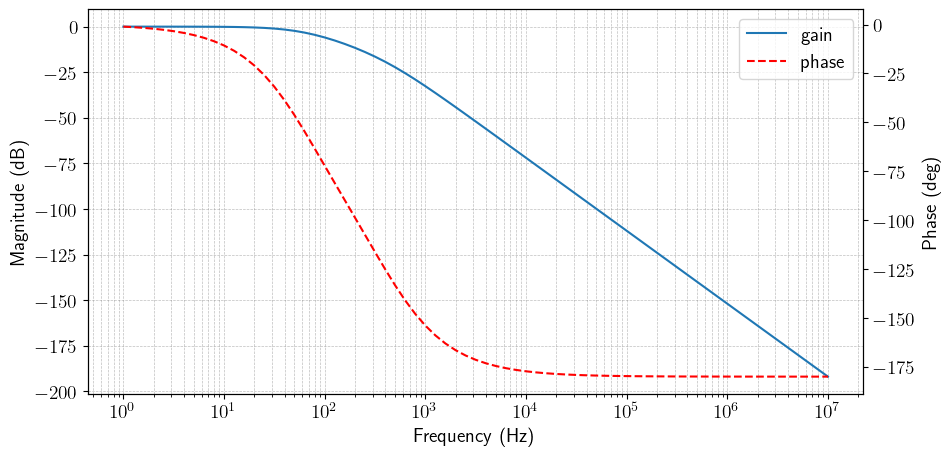

In [40]:
bode_plot(frequency, v_out)

## Example 3: Using Models

In this section, we showcase the different ways models can be incoperated into a
netlist. Models are vital components that enable accurate simulation of
real-world device behavior in a circuit. These models reflect a component's
electrical properties and rely on data from experimental measurements.

![circuit2](./images/cir2.svg)

First, let's build the circuit without the diode

In [41]:
circuit = Circuit('Diode circuit')
circuit.V(1, 'n_in', circuit.gnd, 1@u_V)
circuit.R(1, 'n_in', 'n_out', 1@u_kOhm)
print(circuit)

.title Diode circuit
V1 n_in 0 1V
R1 n_in n_out 1kOhm



### Including a model

There are several ways to include a SPICE model:

1. The first way is to define the model via PySpice
2. The second way is to use raw SPICE syntax
3. The third way is to import the model or subcircuit from a library

#### Method 1: Define the model using via PySpice

In [ ]:
circuit.model('1N4148', 'D',
               IS = 4.352E-9, N = 1.906,   BV = 110,
              IBV = 0.0001,  RS = 0.6458, CJO = 7.048E-13,
               VJ = 0.869,    M = 0.03,    FC = 0.5, TT = 3.48E-9)

We can now include the diode in our circuit

In [ ]:
circuit.D(1, 'n_out', circuit.gnd, model='1N4148')

#### Method 2: Use raw SPICE

In [ ]:
circuit.raw_spice = """
.model 1N4148 D (BV=110 CJO=7.048e-13 FC=0.5 IBV=0.0001 IS=4.352e-09 M=0.03 N=1.906 RS=0.6458 TT=3.48e-09 VJ=0.869)
"""

circuit.D(1, 'n_out', circuit.gnd, model='1N4148')

#### Method 3: Import the subcircuit or model from a library

In [42]:
from PySpice.Spice.Library import SpiceLibrary

In [43]:
spice_library = SpiceLibrary("./models")
circuit.include(spice_library['1N4148'])

We can now include the diode as a subcircuit (since the diode is defined as a
subcircuit in the lib file).

In [44]:
circuit.X('D', '1N4148', 'n_out', circuit.gnd)

SubCircuitElement XD

Print the circuit so far

In [45]:
print(circuit)

.title Diode circuit
.include /home/medwatt/jupyter/pyspice/models/.ipynb_checkpoints/diodes-checkpoint.lib
V1 n_in 0 1V
R1 n_in n_out 1kOhm
XD n_out 0 1N4148



Let's do a DC sweep

In [46]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.dc(V1=slice(0, 1, 0.001))

Get the data points

In [47]:
current = np.array(analysis['V1'])
sweep = np.array(analysis.sweep)

Plot the current vs. voltage

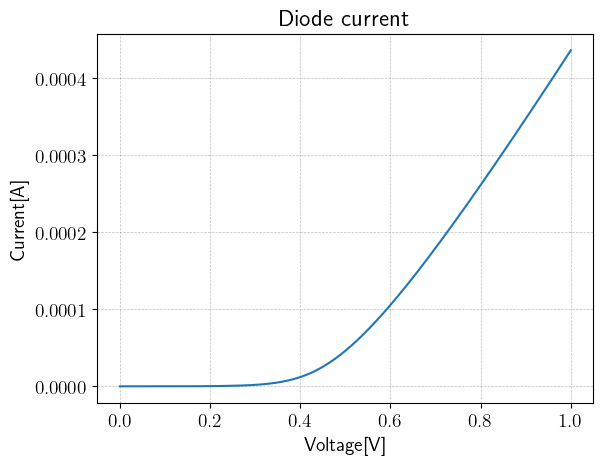

In [48]:
fig, ax = plt.subplots()

ax.set(xlabel="Voltage[V]",
       ylabel="Current[A]",
       title ="Diode current")

ax.plot(sweep, -current)

ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.show()

## Example 4: Using Initial Values

This section focuses on the process of setting initial values for components
(for example, to inform the circuit that a capacitor is already charged to some
voltage before the simulation stars). Apart from that, setting the initial
value of a component can help the simulation converge to a stable solution more
quickly.

![circuit4](./images/cir4.svg)

In [49]:
circuit = Circuit('Capacitor Charging Circuit')

circuit.V(1, 'n_in', 0, 5)
circuit.PulseVoltageSource(2, 'n_swp', 0, initial_value=0, pulsed_value=1, pulse_width=1, period=2,
                           delay_time=2@u_ns, rise_time=0, fall_time=0, phase=None, dc_offset=0)
circuit.VoltageControlledSwitch(1, 'n_r1', 'n_in', 'n_swp', 0, model='switch1')
circuit.model('switch1', 'SW',  Ron=.002@u_Ohm,  Roff=1@u_MOhm)
circuit.R(1, 'n_r1', 'n_c1', 1@u_kOhm)
circuit.C(1, 'n_c1', 0, 1@u_pF, ic=2@u_V)
print(circuit)

.title Capacitor Charging Circuit
V1 n_in 0 5
V2 n_swp 0 DC 0V PULSE(0V 1V 2ns 0s 0s 1s 2s)
S1 n_r1 n_in n_swp 0 switch1
R1 n_r1 n_c1 1kOhm
C1 n_c1 0 1pF ic=2V
.model switch1 SW (Roff=1MegOhm Ron=0.002Ohm)



Let's do a transient simulation

In [50]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=0.01e-9, end_time=6e-9, use_initial_condition=True) # notice `use_initial_condition`

In [51]:
time_values = analysis.time
v_pulse = analysis.nodes['n_swp']
v_c1 = analysis.nodes['n_c1']

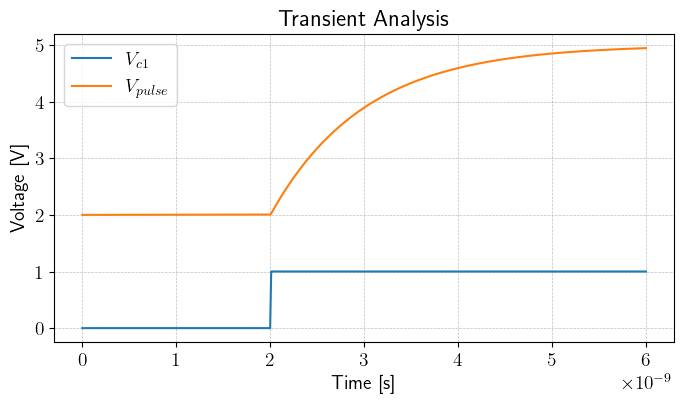

In [53]:
fig, ax = plt.subplots(figsize=(8,4))

ax.set(xlabel="Time [s]",
       ylabel="Voltage [V]",
       title ="Transient Analysis")

ax.plot(time_values, v_pulse, label='$V_{c1}$')
ax.plot(time_values, v_c1, label='$V_{pulse}$')

ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

ax.legend()

plt.show()

## Example 6: Frequency Domain Analysis

Here, we show how we can perform a frequency domain analysis (via the `fft`) of
the output voltage of a half-wave rectifier.

![circuit6](./images/cir2.svg)

In [54]:
from scipy.fftpack import fft, fftfreq

In [55]:
circuit = Circuit('Diode Rectifier')

source_frequency = 1e3

circuit.SinusoidalVoltageSource(1, 'n_in', 0, amplitude=3, frequency=source_frequency)

circuit.R(1, 'n_in', 'n_out', 1@u_kOhm)

circuit.D(1, 'n_out', circuit.gnd, model='1N4148')
circuit.raw_spice = """
.model 1N4148 D (BV=110 CJO=7.048e-13 FC=0.5 IBV=0.0001 IS=4.352e-09 M=0.03 N=1.906 RS=0.6458 TT=3.48e-09 VJ=0.869)
"""

print(circuit)

.title Diode Rectifier

.model 1N4148 D (BV=110 CJO=7.048e-13 FC=0.5 IBV=0.0001 IS=4.352e-09 M=0.03 N=1.906 RS=0.6458 TT=3.48e-09 VJ=0.869)
V1 n_in 0 DC 0V AC 1V SIN(0V 3V 1000.0Hz 0s 0Hz)
R1 n_in n_out 1kOhm
D1 n_out 0 1N4148



We need to sample the time-domain signal before we can perform the fft

In [56]:
reference_signal_period = 1 / source_frequency
sample_points_per_period = 50
number_of_periods_to_capture = 50

sampling_time = reference_signal_period / sample_points_per_period
end_time = number_of_periods_to_capture * reference_signal_period

In [57]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.transient(step_time=sampling_time, end_time=end_time)

In [58]:
time_values = np.array(analysis.time)
v_in = np.array(analysis['n_in'])
v_out = np.array(analysis['n_out'])

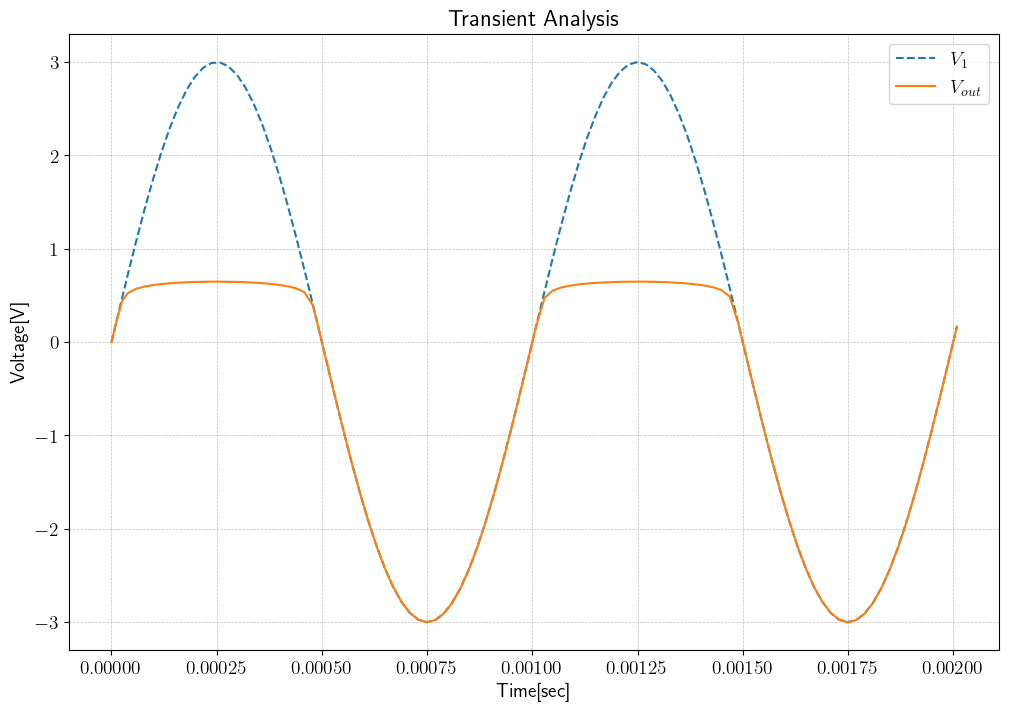

In [59]:
fig, ax = plt.subplots(figsize=(12,8))

# setup plot
ax.set(xlabel="Time[sec]",
       ylabel="Voltage[V]",
       title ="Transient Analysis")

ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

# just plot 2 periods to avoid congestion in the plot
stop = sample_points_per_period * 2 + len(time_values) - sample_points_per_period * number_of_periods_to_capture

ax.plot(time_values[:stop], v_in[:stop], linestyle = 'dashed', label='$V_{1}$')
ax.plot(time_values[:stop], v_out[:stop], label='$V_{out}$')
ax.legend()

plt.show()

In [60]:
def plot_frequency_spectrum(sampling_time, time_values, signal):
    
    # total number of sample points
    N = len(time_values)

    # sampling time
    T = sampling_time

    # translate time-domain signal to the frequency domain via the fft
    xf = fftfreq(N, T)[:N//2]
    yf = fft(signal - np.mean(signal)) # remove the dc
    spectrum = 2.0/N * np.abs(yf[0:N//2])
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Frequency Spectrum')
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Amplitude')
    ax.grid()
    ax.plot(xf, spectrum)
    plt.show()

The input is a pure sine wave. So, we should see a single peak in the frequency domain.

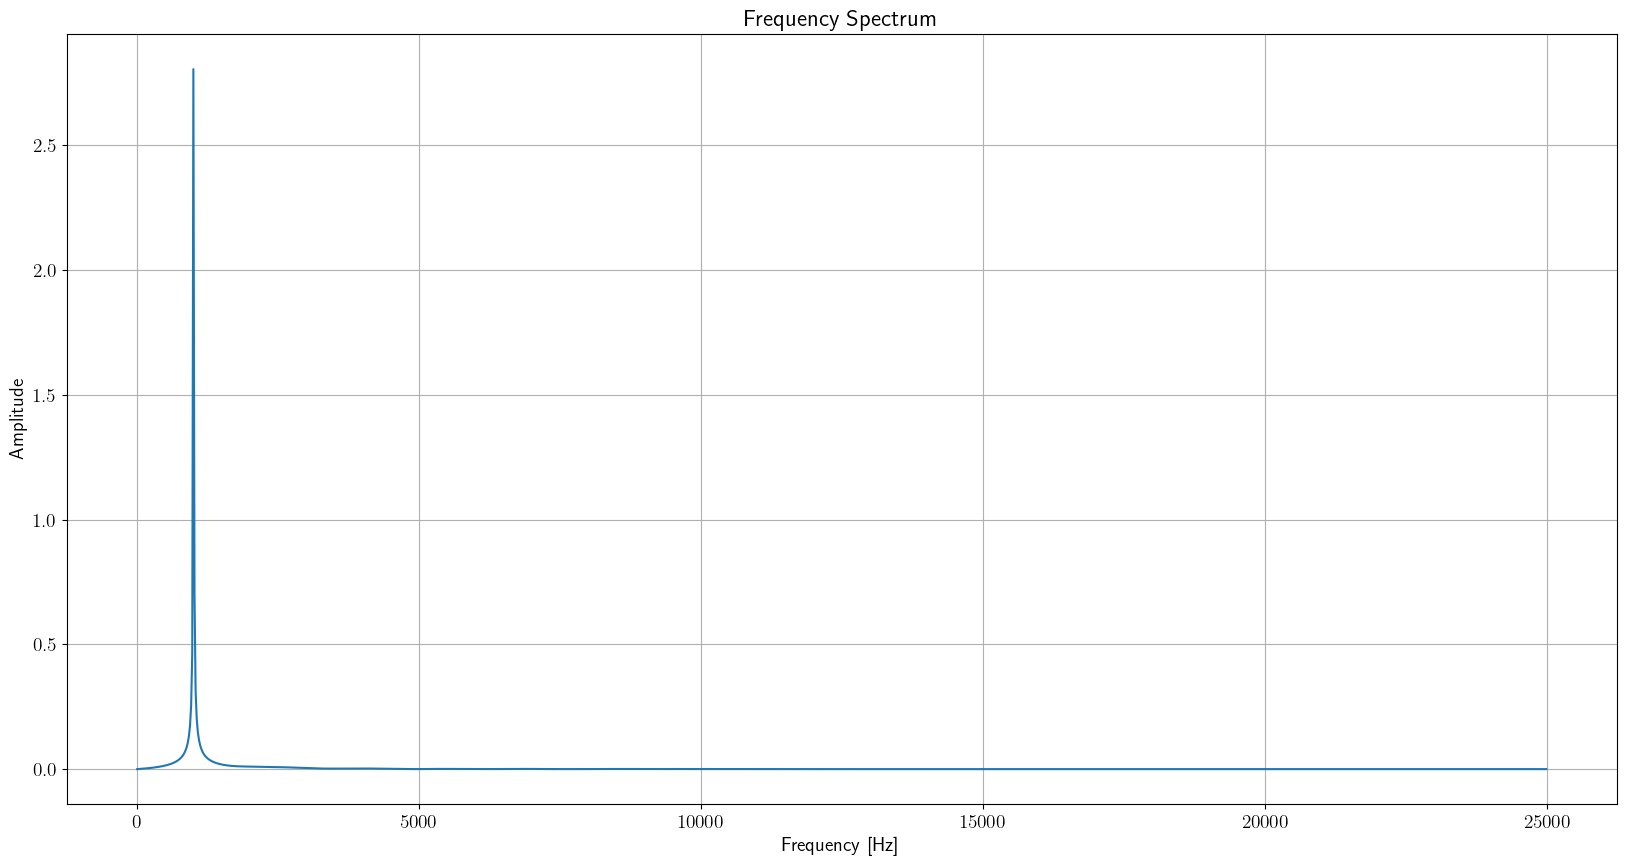

In [61]:
plot_frequency_spectrum(sampling_time, time_values, v_in)

The output waveform is distorted. So, we should should see high frequency harmonics in the frequency plot.

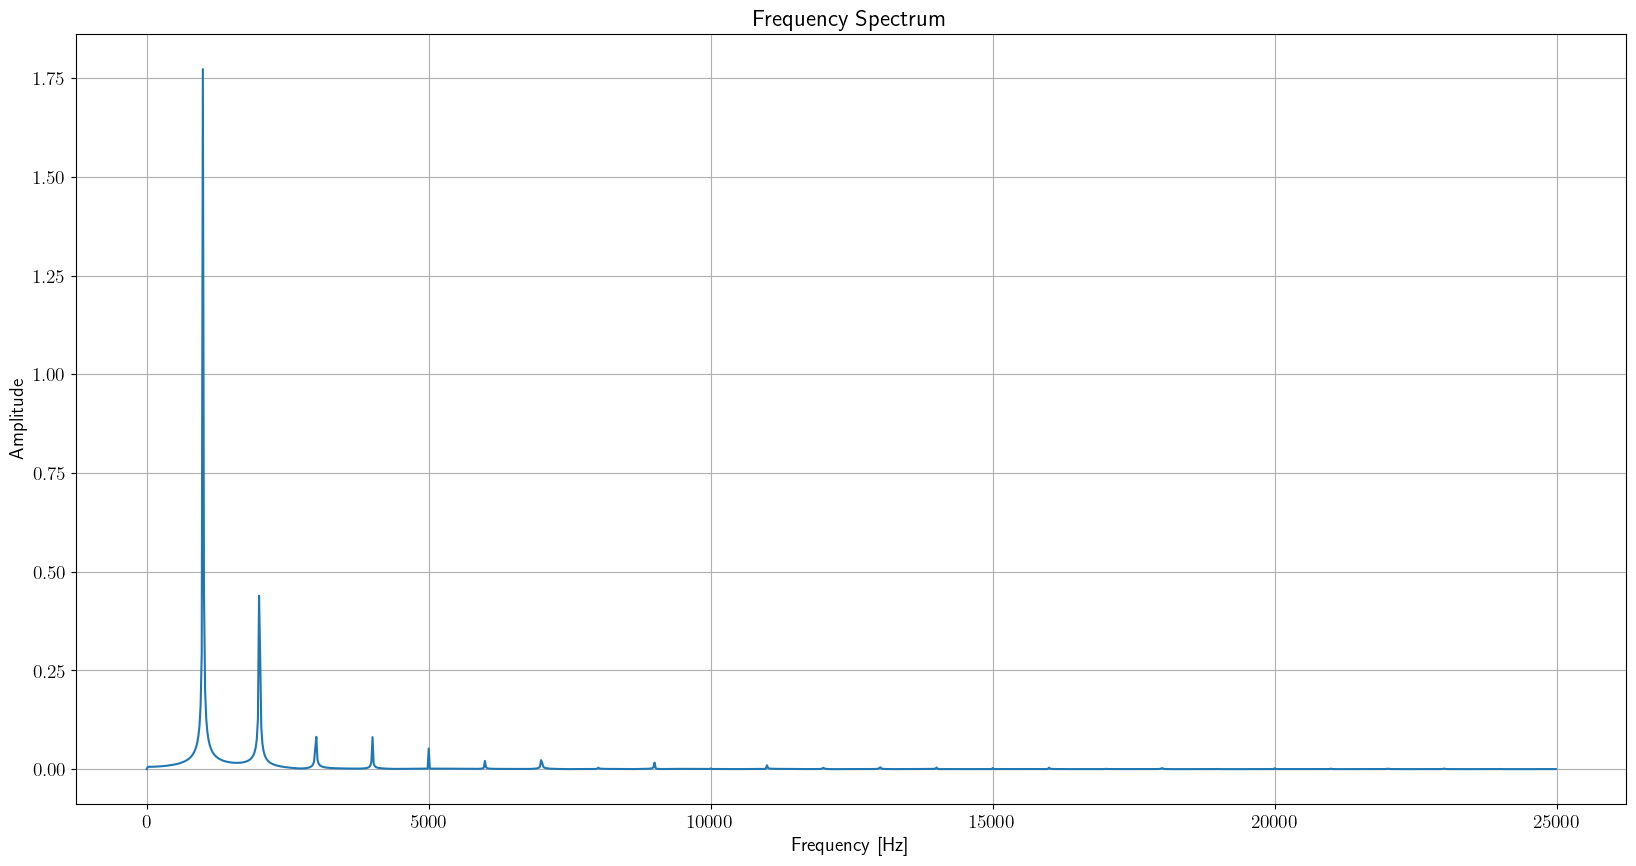

In [62]:
plot_frequency_spectrum(sampling_time, time_values, v_out)

## Example 7: Internal Parameters

In the example here, we measure how the drain current, output voltage,
transconductance, and output resistance of the MOSFET changes as we sweep the
gate voltage. The transconductance and output resistance are internal
parameters of a MOSFET. We need to specifically ask the simulator to save these
values during the simulation.

![circuit3](./images/cir3.svg)

In [63]:
circuit = Circuit('MOS circuit')
circuit.V('GG', 'VGG', 0, 2.5)
circuit.V('DD', 'VDD', 0, 5)
circuit.R('D', 'VDD', 'VD', 1e3)
circuit.M('n', 'VD', 'VGG', 0, 0, model='NMOS-SH', l=1e-6, w=10e-6)
circuit.model('NMOS-SH', 'nmos', Kp=190E-6, Vto=0.57, Lambda=0.16, Gamma=0.50, Phi=0.7)
print(circuit)

.title MOS circuit
VGG VGG 0 2.5
VDD VDD 0 5
RD VDD VD 1000.0
Mn VD VGG 0 0 NMOS-SH l=1e-06 w=1e-05
.model NMOS-SH nmos (Gamma=0.5 Kp=0.00019 Lambda=0.16 Phi=0.7 Vto=0.57)



Save internal parameters of the mosfet

In [64]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)

In [65]:
parameter_names = ["gm", "gds", "id"]
simulator.save_internal_parameters(*[f'@mn[{param}]' for param in parameter_names])

In [66]:
print(simulator)

.title MOS circuit
VGG VGG 0 2.5
VDD VDD 0 5
RD VDD VD 1000.0
Mn VD VGG 0 0 NMOS-SH l=1e-06 w=1e-05
.model NMOS-SH nmos (Gamma=0.5 Kp=0.00019 Lambda=0.16 Phi=0.7 Vto=0.57)
.options TEMP = 25C
.options TNOM = 25C
.save all @mn[gds] @mn[id] @mn[gm]
.end



Sweep the gate voltage

In [67]:
analysis = simulator.dc(VGG=slice(0, 5, 0.1))

Get results

In [68]:
param_result = {}
for param in parameter_names:
    param_result[param] = np.array(analysis[f'@mn[{param}]'])
    
vgg = analysis.sweep
vd = analysis.nodes['vd']

Plot

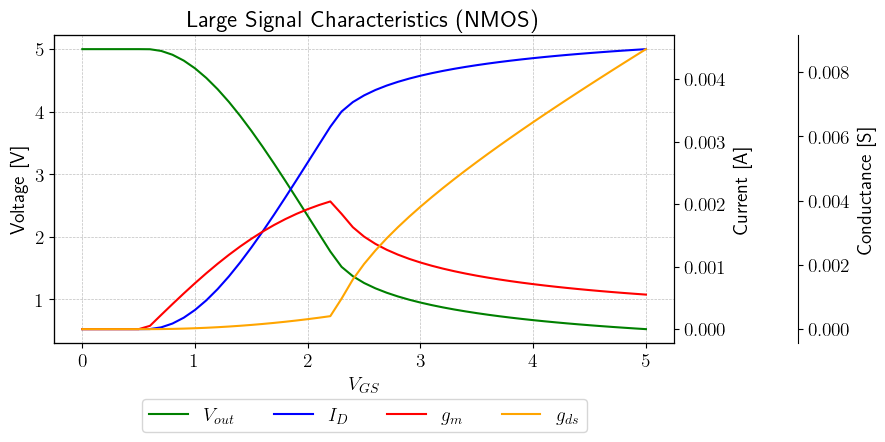

In [70]:
fig, ax_voltage = plt.subplots(figsize=(8,4))
ax_current = ax_voltage.twinx()
ax_conductance = ax_voltage.twinx()

# Offset the right spine of ax3
ax_conductance.spines["right"].set_position(("axes", 1.2))

ax_voltage.set_ylabel("Voltage [V]")
ax_current.set_ylabel("Current [A]")
ax_conductance.set_ylabel("Conductance [S]")

ax_voltage.set_xlabel("$V_{GS}$")
ax_voltage.set_title("Large Signal Characteristics (NMOS)")

p1 = ax_voltage.plot(vgg, vd, label='$V_{out}$', color="green")
p2 = ax_current.plot(vgg, param_result["id"], label='$I_{D}$', color="blue")
p3 = ax_conductance.plot(vgg, param_result["gm"], label='$g_{m}$', color="red")
p4 = ax_conductance.plot(vgg, param_result["gds"], label='$g_{ds}$', color="orange")

ax_voltage.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

# create the legend and set its location
lines = p1 + p2 + p3 + p4
labels = [l.get_label() for l in lines]
ax_voltage.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)

plt.show()

## NgSpice Shared

In [ ]:
from PySpice.Spice.NgSpice.Shared import NgSpiceShared

In [ ]:
circuit = """
.title Resistive Divider
V1 n_in 0 5V
R1 n_in n_out 2kOhm
R2 n_out 0 8kOhm
.options TEMP = 25C
.options TNOM = 25C
.op
.end
"""

In [ ]:
ngspice = NgSpiceShared.new_instance()
ngspice.load_circuit(circuit)
ngspice.run()

In [ ]:
print('Plots:', ngspice.plot_names)

In [ ]:
for node in ngspice.plot('', ngspice.last_plot).nodes():
    print(str(node), np.array(node))

In [ ]:
ngspice.exec_command(f'alter r1=10k')
ngspice.run()

In [ ]:
print('Plots:', ngspice.plot_names)

In [ ]:
for node in ngspice.plot('', 'op2').nodes():
    print(str(node), np.array(node))

In [ ]:
ngspice.destroy()